In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk as nlp
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import re

from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

ModuleNotFoundError: No module named 'wordcloud'

In [5]:
data = pd.read_csv("JobAnalyst_Dice.csv")
data.head()

,Unnamed: 0,Name,Link,Advertiser,Description
0,0,Cybersecurity Analyst with Project Coordinator...,https://www.dice.com/jobs/detail/5c9720a5cf20b...,Strategic Systems Inc,\nthis is a 100% Remote positionTitle: Cyberse...
1,1,Senior Cybersecurity Analyst - SIEM SME,https://www.dice.com/jobs/detail/940e2bd0f2b08...,QED National,\nA leading NYC academic medical center is loo...
2,2,CyberSecurity Analyst,https://www.dice.com/jobs/detail/23aebf6900cb7...,"GlobalLogic, Inc.",\nJob Description5-10 years of experience with...
3,3,Cybersecurity Analyst I,https://www.dice.com/jobs/detail/4e9185c637e66...,Alliant Energy,\nPosting Details Alliant Energy has an outsta...
4,4,Cybersecurity Analyst (with Reporting),https://www.dice.com/jobs/detail/469eb119c743f...,Absolute Information Technologies Inc.,\n Title Cybersecurity Analyst (with Re...


In [6]:
print(data.Description[1][:500], "...")
print("\ntotal length", len(data.Description[1]))


A leading NYC academic medical center is looking for a Senior Cybersecurity Analyst  - SIEM SME for a contract to hire role in NYC. Please note: This position will require onsite work.Minimum QualificationsBachelor's degree with a focus in Information Security, Computer Science or Computer EngineeringDemonstrated experience managing a SIEM within an enterprise-level information security programFamiliarity with data lakes or big data technologies and integrations is desired Knowledge & Experienc ...

total length 4382


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   94 non-null     int64 
 1   Name         94 non-null     object
 2   Link         94 non-null     object
 3   Advertiser   94 non-null     object
 4   Description  94 non-null     object
dtypes: int64(1), object(4)
memory usage: 3.8+ KB


In [8]:
data.Description = data.Description.apply(lambda x: re.sub("(\W)", " ", x))
tokenizer = nlp.WordPunctTokenizer()
data["word_count"] = data.Description.apply(lambda x: len(tokenizer.tokenize(x)))
data[["word_count", "Description"]].head()

,word_count,Description
0,223,this is a 100 Remote positionTitle Cybersec...
1,606,A leading NYC academic medical center is look...
2,190,Job Description5 10 years of experience withi...
3,505,Posting Details Alliant Energy has an outstan...
4,443,Title Cybersecurity Analyst with Rep...


In [9]:
freq = pd.Series(" ".join(data.Description).split()).value_counts()
print(freq.head(10))
print(freq.tail(10))

and         3032
to          1416
of          1294
the         1270
in           779
a            717
security     620
with         600
for          574
or           563
dtype: int64
strict          1
obtaining       1
introduction    1
release         1
NISPOM          1
DCID            1
tailoring       1
ST              1
accrediting     1
26099           1
dtype: int64


In [10]:
lemma = nlp.WordNetLemmatizer()
data.Description = data.Description.apply(lambda x: lemma.lemmatize(x))
data.Description = data.Description.apply(lambda x: x.lower())

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hannah叶\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

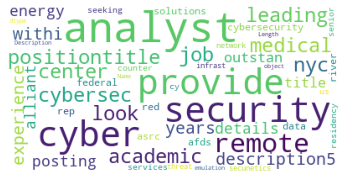

In [16]:
stopword_list = set(stopwords.words("english"))

word_cloud = WordCloud(
                          background_color='white',
                          stopwords=stopword_list,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(data.Description))
print(word_cloud)
fig = plt.figure(1)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [17]:
tf_idf = TfidfVectorizer(max_df=0.8,stop_words=stopword_list, max_features=10000, ngram_range=(1,3))
tf_idf.fit(data.Description)

TfidfVectorizer(max_df=0.8, max_features=10000, ngram_range=(1, 3),
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [29]:
doc = pd.Series(data.Description[93])
doc_vector = tf_idf.transform(doc)

In [30]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(doc_vector.tocoo())
#extract only the top n; n here is 10
feature_names = tf_idf.get_feature_names()
keywords=extract_topn_from_vector(feature_names,sorted_items,5)

In [31]:
# now print the results
print("\nDescription:")
print(doc[0][:1000])


Description:
    cyber security analyst   threat emulation  jbsa 21 0344 w    bowhead seeks a cyber security analyst   threat emulation to support the afcert dco hac contract in san antonio  tx  the ability of the afcert to complete its mission is dependent upon the ability to develop methods to identify  contain  log and analyze security vulnerabilities holes on air force systems cte a analyst contractor employees may be required to provide 24 hour coverage  work  for seven  7  days a week  365 days a year with zero tolerance for error     conduct both automated and manual enterprise vulnerability assessments  including conducting regular patch   configuration vulnerability assessments as directed by operational flight leads    conduct cyber threat emulation operations  and coordinate with security teams to strengthen the overall security posture of the afnet and afin various tools and capabilities    test for real time security vulnerabilities  conduct assessments  and assess vulner

In [32]:
print("Keywords:")
for k in keywords:
    print(k,keywords[k])

Keywords:
uic 0.177
threat emulation 0.129
emulation 0.129
bowhead 0.11
employees 0.095
